In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def load_images(fname, disparityRange):
    left = cv2.cvtColor(cv2.imread(fname + '_left.png', ), cv2.COLOR_BGR2RGB)
    right = cv2.cvtColor(cv2.imread(fname + '_right.png', ), cv2.COLOR_BGR2RGB)

    print('Left  - ', left.shape)
    print('Right - ', right.shape)

    fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(left)
    ax[0].axis('off')
    ax[0].set_title('Left Image')
    ax[1].imshow(right)
    ax[1].axis('off')
    ax[1].set_title('Right Image')
    plt.tight_layout()
    plt.savefig('{:s}_{:02d}d_01_Original.png'.format(fname, disparityRange), dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
    return left, right

In [3]:
def get_composite(left, right, fname, disparityRange):# Composite Image
    leftR = left[:, :, 0:1]
    rightGB = right[:, :, 1:3]

    print('Left  R  - ', leftR.shape)
    print('Right GB - ', rightGB.shape)

    catImage = np.concatenate((leftR, rightGB), axis=2)
    print('\nConcat Image - ', catImage.shape)

    plt.figure(figsize=(8, 8))
    plt.imshow(catImage)
    plt.axis('off')
    plt.title('Composite Image')
    plt.tight_layout()
    plt.savefig('{:s}_{:02d}d_02_Composite.png'.format(fname, disparityRange), dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
    return catImage

In [7]:
def block_matching(left, right, disparityRange): # Basic Block Matching
    print('Performing Basic Block Matching')
    print()
    stime = time.time()

    leftI = np.mean(left, axis=2)
    rightI = np.mean(right, axis=2)

    print('Left  Gray - ', leftI.shape)
    print('Right Gray - ', rightI.shape)
    print()

    # Result of Block Matching
    DbasicSubpixel = np.zeros(leftI.shape, dtype='float32')
    print('DbasicSubpixel - ', DbasicSubpixel.shape)

    # Block Size for Block Matching
    halfBlockSize = 2;
    blockSize = 2 * halfBlockSize + 1;

    imgHeight, imgWidth = leftI.shape

    print()

    for m in range(imgHeight):
        minr = max(0, m-halfBlockSize)
        maxr = min(imgHeight-1, m+halfBlockSize)

        for n in range(imgWidth):
            print('{:03d}/{:03d} - {:03d}/{:03d}'.format(m, imgHeight, n, imgWidth), end='\r')
            minc = max(0, n-halfBlockSize)
            maxc = min(imgWidth-1, n+halfBlockSize)

#             mind = max(-disparityRange, 0-minc)
            mind = 0
            maxd = min(disparityRange, imgWidth-maxc)

            template = rightI[minr:maxr, minc:maxc]
            numBlocks = maxd - mind + 1

            blockDiffs = np.zeros((numBlocks))

            for i in range(mind, maxd+1):
                block = leftI[minr:maxr, (minc + i):(maxc + i)];
                blockIndex = i - mind
                blockDiffs[blockIndex] = np.sum(np.sum(np.abs(template - block)))

            bestMatchIndex = np.argmin(blockDiffs)

            d = bestMatchIndex + mind

            if bestMatchIndex == 0 or bestMatchIndex == numBlocks-1:
                DbasicSubpixel[m, n] = d
            else:
                C1 = blockDiffs[bestMatchIndex - 1]
                C2 = blockDiffs[bestMatchIndex]
                C3 = blockDiffs[bestMatchIndex + 1]

                DbasicSubpixel[m, n] = d - (0.5 * (C3-C1) / (C1 - (2*C2) + C3))
    etime = time.time()

    print('Time Elapsed - {:5.2f} Seconds\t\t\t'.format(etime-stime))

    return DbasicSubpixel, blockSize

In [8]:
def print_disparitymap(DbasicSubpixel, fname, disparityRange, blockSize): # Visual Disparity Map
    print('Displaying Disparity Map')
    print()

    plt.figure(dpi = 150)
    im = plt.imshow(DbasicSubpixel, cmap='jet')
    plt.colorbar(im)
    plt.axis('off')
    plt.title('Basic block matching, Sub-px acc., Search right, Block size = {:d}'.format(blockSize))
    plt.tight_layout()
    plt.savefig('{:s}_{:02d}d_03_Disparity.png'.format(fname, disparityRange), dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
    plt.figure(dpi = 150)
    im = plt.imshow(DbasicSubpixel, cmap='gray')
    plt.colorbar(im)
    plt.axis('off')
    plt.title('Basic block matching, Sub-px acc., Search right, Block size = {:d}'.format(blockSize))
    plt.tight_layout()
    plt.savefig('{:s}_{:02d}d_03_Disparity_gray.png'.format(fname, disparityRange), dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
def print_difference(DbasicSubpixel, fname, disparityRange):
    print('Displaying Disparity Map')
    print()

    gt = cv2.cvtColor(cv2.imread(fname + '_gt.png', ), cv2.COLOR_BGR2GRAY)
    
    plt.figure(dpi = 150)
    im = plt.imshow(np.abs(DbasicSubpixel-gt), cmap='jet')
    plt.colorbar(im)
    plt.axis('off')
    plt.title('Difference')
    plt.tight_layout()
    plt.savefig('{:s}_{:02d}d_04_Difference.png'.format(fname, disparityRange), dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
    plt.figure(dpi = 150)
    im = plt.imshow(np.abs(DbasicSubpixel-gt), cmap='gray')
    plt.colorbar(im)
    plt.axis('off')
    plt.title('Difference')
    plt.tight_layout()
    plt.savefig('{:s}_{:02d}d_04_Difference_gray.png'.format(fname, disparityRange), dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()

Left  -  (375, 450, 3)
Right -  (375, 450, 3)


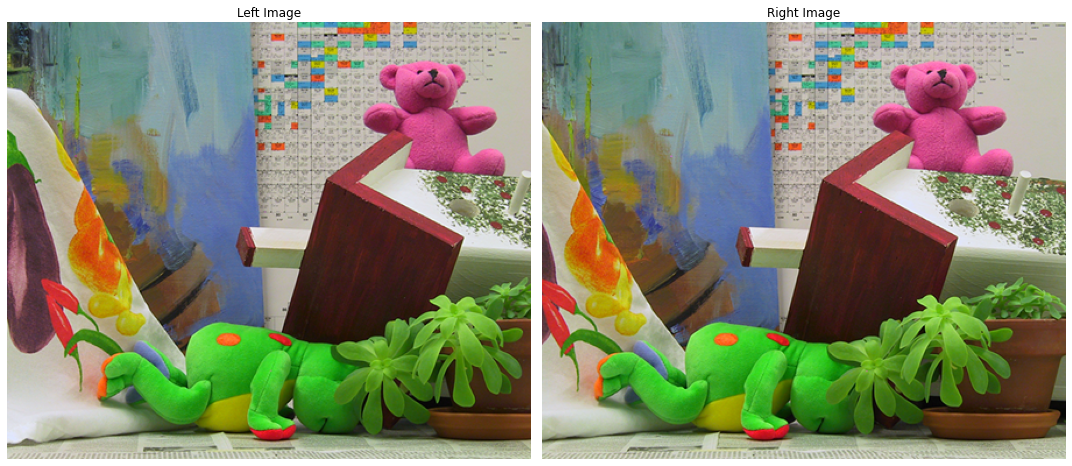

Left  R  -  (375, 450, 1)
Right GB -  (375, 450, 2)

Concat Image -  (375, 450, 3)


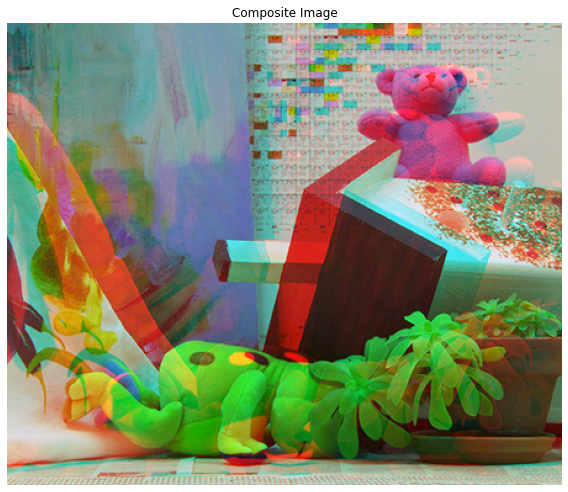

Performing Basic Block Matching

Left  Gray -  (375, 450)
Right Gray -  (375, 450)

DbasicSubpixel -  (375, 450)

Time Elapsed - 121.23 Seconds			
Displaying Disparity Map



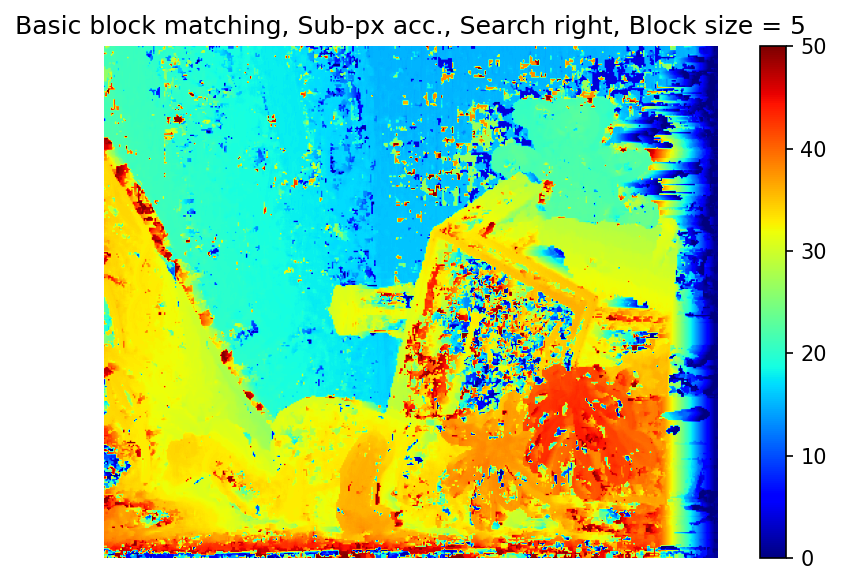

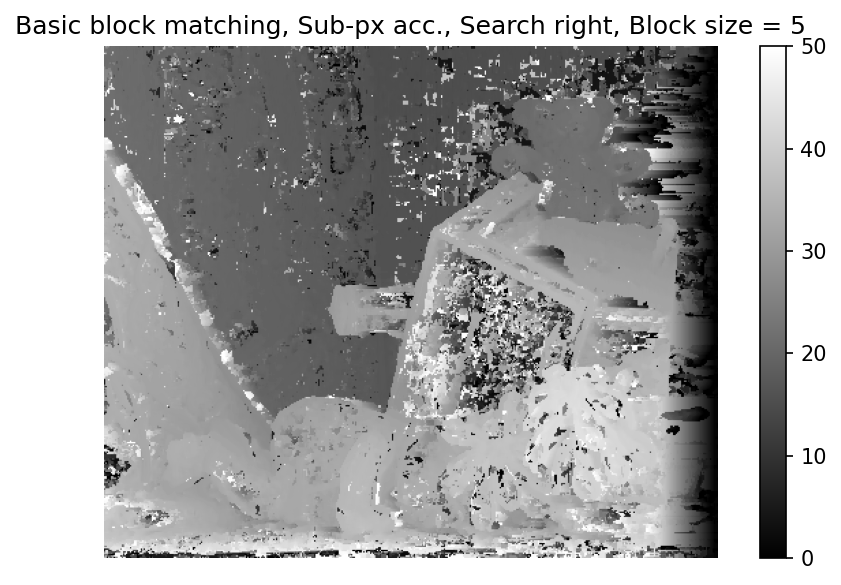

Displaying Disparity Map



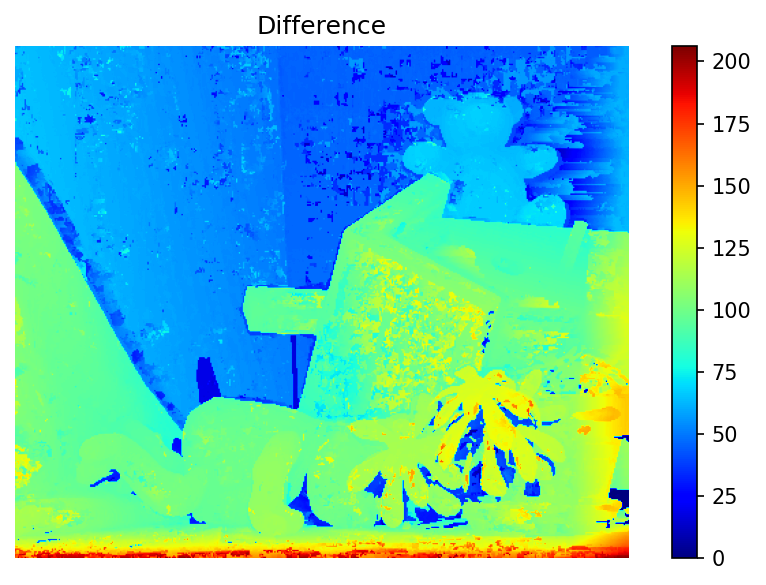

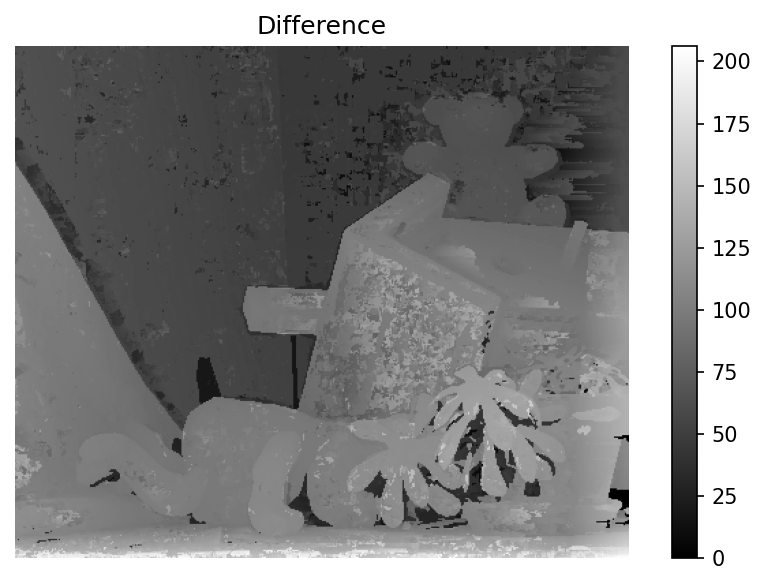

In [9]:
fname = 'teddy'

# for disparityRange in range(10, 101, 10):
disparityRange = 50

left, right = load_images(fname, disparityRange)
catImage = get_composite(left, right, fname, disparityRange)
DbasicSubpixel, blockSize = block_matching(left, right, disparityRange)
print_disparitymap(DbasicSubpixel, fname, disparityRange, blockSize)
print_difference(DbasicSubpixel, fname, disparityRange)